# MNIST Code Along with ANN
Before we start working with Convolutional Neural Networks (CNN), let's model the <a href='https://en.wikipedia.org/wiki/MNIST_database'>MNIST dataset</a> using only linear layers.<br>
In this exercise we'll use the same logic laid out in the ANN notebook. We'll reshape the MNIST data from a 28x28 image to a flattened 1x784 vector to mimic a single row of 784 features.

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import DataLoader  # lets us load data in batches
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST dataset


In [51]:
# convert images to tensor
transform = transforms.ToTensor()

In [52]:
train_data = datasets.MNIST(root='', train=True, download=True, transform=transform)
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [53]:
test_data = datasets.MNIST(root='', train=False, download=True, transform=transform)
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [54]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [55]:
image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


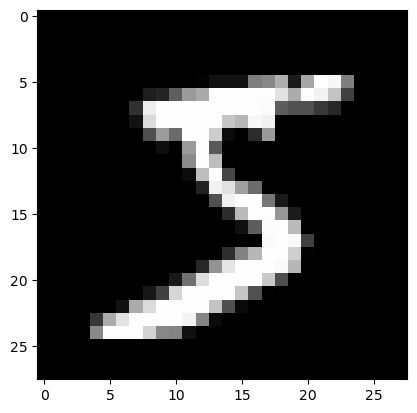

In [56]:
# view the image
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gray");

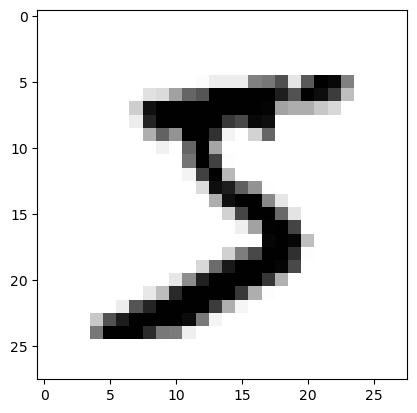

In [57]:
plt.imshow(train_data[0][0].reshape((28,28)), cmap="gist_yarg");

In [58]:
torch.manual_seed(101)  # for consistent results

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

### View a batch of images
Once we've defined a DataLoader, we can create a grid of images using <a href='https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid'><tt><strong>torchvision.utils.make_grid</strong></tt></a>

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


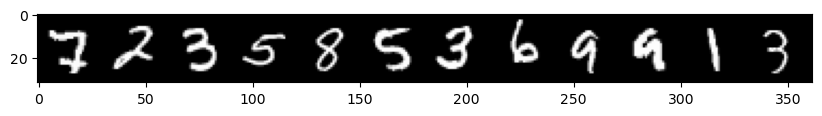

In [60]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model
For this exercise we'll use fully connected layers to develop a <a href='https://en.wikipedia.org/wiki/Multilayer_perceptron'>multilayer perceptron</a>.<br>
Our input size is 784 once we flatten the incoming 28x28 tensors.<br>
Our output size represents the 10 possible digits.<br>
We'll set our hidden layers to [120, 84] for now. Once you've completed the exercise feel free to come back and try different values.

In [62]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [63]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

<div class="alert alert-info"><strong>NOTE:</strong> You may have noticed our shortcut for adding ReLU to the linear layer. In the last section this was done under the <tt>__init__</tt> section as
<pre style='background-color:rgb(217,237,247)'>
layerlist = []
for i in layers:
    layerlist.append(nn.Linear(n_in,i)) 
    layerlist.append(nn.ReLU(inplace=True))
self.layers = nn.Sequential(*layerlist)</pre>
    
Here we're calling <tt>F.relu()</tt> as a functional wrapper on the linear layer directly:
<pre style='background-color:rgb(217,237,247)'>
def forward(self,X):
    X = F.relu(self.fc1(X))</pre></div>

In [65]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [66]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [68]:
# Load the first batch, print its shape
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    
# EQUIVALENT TO:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print('Batch shape:', images.size())

Batch shape: torch.Size([100, 1, 28, 28])


In [69]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955003  accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27258992  accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18161939  accuracy:  89.317%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.17169753  accuracy:  94.625%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.05035120  accuracy:  94.993%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.13971618  accuracy:  95.252%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16996950  accuracy:  96.540%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.17838547  accuracy:  96.525%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.10648929  accuracy:  96.613%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.14351197  accuracy:  97.450%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.01262849  accuracy:  97.485%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.07901122  accuracy:  97.428%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05079358  accuracy:  98.040%
epoch:  4  b

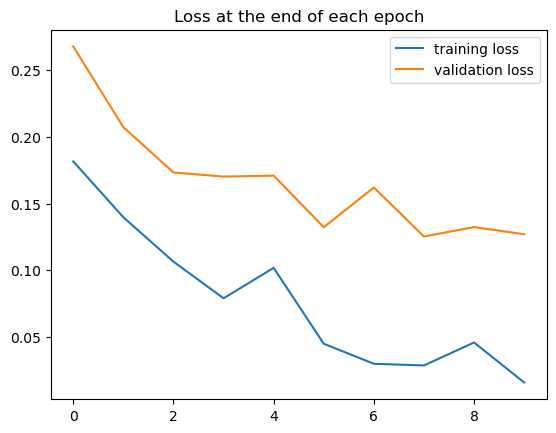

In [108]:
train_losses = [loss.detach().numpy() for loss in train_losses]
test_losses = [loss.detach().numpy() for loss in test_losses]

# Now you can plot the losses
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()


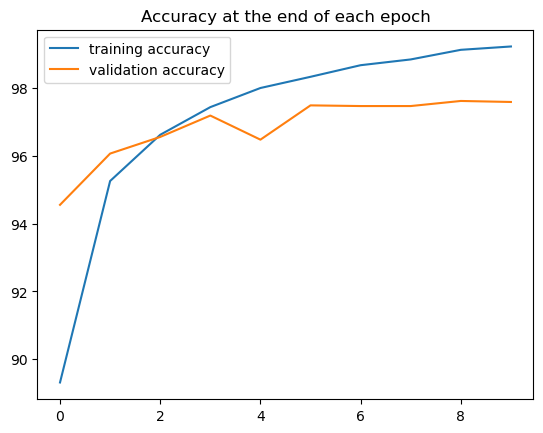

In [110]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [112]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(9455), tensor(9606), tensor(9655), tensor(9718), tensor(9647), tensor(9748), tensor(9746), tensor(9746), tensor(9761), tensor(9758)]

Test accuracy: 97.580%


In [114]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [116]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9758/10000 =  97.580%


In [118]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 972    0    2    1    1    1    3    1    3    5]
 [   0 1123    1    0    1    1    4    6    0    4]
 [   2    3 1019    9    5    0    2   15    3    0]
 [   0    3    2  987    0   20    1    4    4    9]
 [   0    0    1    0  951    1    1    0    0    6]
 [   0    0    0    1    0  846    1    0    2    6]
 [   3    2    2    1    9   10  945    0    2    1]
 [   0    0    2    2    2    1    0  991    1    2]
 [   3    4    2    8    3   10    1    5  957    9]
 [   0    0    1    1   10    2    0    6    2  967]]


In [120]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

242

In [122]:
misses[:10]

array([   8,   18,   33,  115,  149,  151,  241,  247,  259,  274])

In [124]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [   8   18   33  115  149  151  241  247  259  274  321  340]
Label: [   5    3    4    4    2    9    9    4    6    9    2    5]
Guess: [   6    8    0    9    9    8    8    2    0    3    7    3]


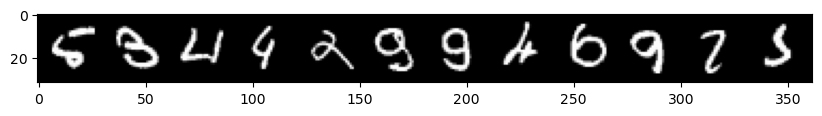

In [126]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));